# Sentiment analysis with IMDB dataset

- The dataset consists movie reviews that are labeled as either positive or negative

- Positive means that a movie was rated with more than six stars on IMDb

- Negative means that a movie was rated with fewer than five stars on IMDb

- The aim of this task to classify whether a review is positive or negative

In [1]:
import pyprind
import pandas as pd
import os
import numpy as np
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import seaborn as sns
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_style('whitegrid')
pd.set_option('display.max_colwidth', -1)

In [2]:
data_source = '/Users/wkfong/datasets/aclImdb/'
folders = ('train', 'test')
labels = {'pos': 1, 'neg': 0}
n_doc = sum([len(os.listdir(os.path.join(data_source, f, l))) 
                 for f in folders 
                 for l in labels])
raw_movie_reviews_path = os.path.join(data_source, 'raw_movie_reviews.csv')
processed_movie_reviews_path = os.path.join(data_source, 'processed_movie_reviews.csv')
construct_raw_data = False
process_raw_data = False
train_pct = 0.7

# setup progress bar
pbar = pyprind.ProgBar(n_doc)

## Construct raw review dataset

In [3]:
if construct_raw_data:

    raw_movie_reviews = pd.DataFrame()

    for s in ('test', 'train'):
        for l in ('pos', 'neg'):
            path = os.path.join(data_source, f'{s}/{l}')
            for file in os.listdir(path):
                with open(os.path.join(path, file), 'r') as infile:
                    txt = infile.read()
                    raw_movie_reviews = raw_movie_reviews.append([[txt, labels[l]]], ignore_index=True)
                    pbar.update()

    raw_movie_reviews.columns = ['review', 'sentiment']

    # shuffle the dataframe
    np.random.seed(0)
    raw_movie_reviews = raw_movie_reviews.reindex(np.random.permutation(df.index))

    # persist the constructed dataset
    raw_movie_reviews.to_csv(raw_movie_reviews_path, index=False)
    
else:
    
    raw_movie_reviews = pd.read_csv(raw_movie_reviews_path)

In [4]:
raw_movie_reviews.head()

review  \
0  My family and I normally do not watch local movies for the simple reason that they are poorly made, they lack the depth, and just not worth our time.<br /><br />The trailer of "Nasaan ka man" caught my attention, my daughter in law's and daughter's so we took time out to watch it this afternoon. The movie exceeded our expectations. The cinematography was very good, the story beautiful and the acting awesome. Jericho Rosales was really very good, so's Claudine Barretto. The fact that I despised Diether Ocampo proves he was effective at his role. I have never been this touched, moved and affected by a local movie before. Imagine a cynic like me dabbing my eyes at the end of the movie? Congratulations to Star Cinema!! Way to go, Jericho and Claudine!!                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

## Inspect and clean reviews

Actions:

- Remove HTML markup
- Remove stop words
- Keep emoticon
- Remove non-word characters
- Toggle to lower case
- Word stemming

### Check class balance

Classes are balanced as expected.

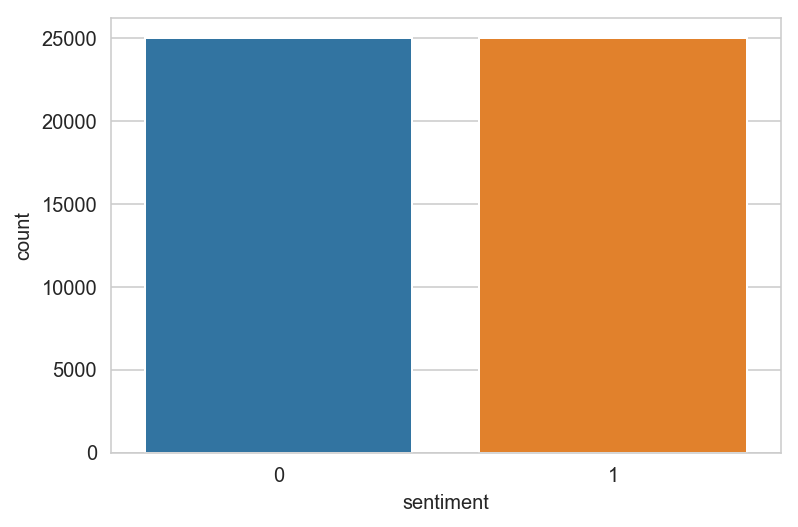

In [5]:
sns.countplot(raw_movie_reviews['sentiment']);

### Is the review length correlated to the sentiment?

Not really, but we can see some very long reviews that are related positive sentiments.

In [25]:
raw_movie_reviews['review_len'] = raw_movie_reviews['review'].apply(len)

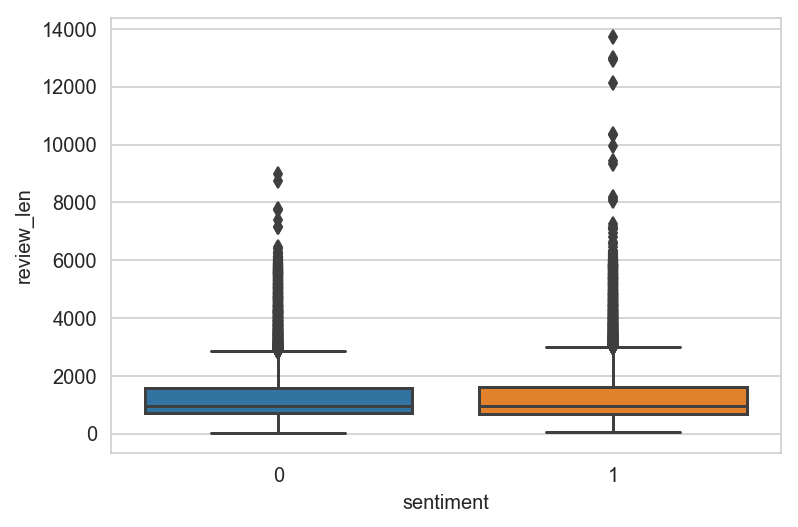

In [39]:
sns.boxplot(x='sentiment', y='review_len', data=raw_movie_reviews);

In [45]:
raw_movie_reviews

review  \
0      My family and I normally do not watch local movies for the simple reason that they are poorly made, they lack the depth, and just not worth our time.<br /><br />The trailer of "Nasaan ka man" caught my attention, my daughter in law's and daughter's so we took time out to watch it this afternoon. The movie exceeded our expectations. The cinematography was very good, the story beautiful and the acting awesome. Jericho Rosales was really very good, so's Claudine Barretto. The fact that I despised Diether Ocampo proves he was effective at his role. I have never been this touched, moved and affected by a local movie before. Imagine a cynic like me dabbing my eyes at the end of the movie? Congratulations to Star Cinema!! Way to go, Jericho and Claudine!!                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [20]:
def tokeniser(text):
    """
    Vanilla split by space
    """
    return text.split()


porter = PorterStemmer()
def tokeniser_porter(text):
    """
    Porter stemming
    """
    return [porter.stem(word) for word in text.split()]


def tokeniser_cutoff(text, n=2):
    """
    Removing terms that are <= n
    """
    return [x for x in text.split() if len(x) > n]


def preprocess(text):
    # remove html markup
    soup = BeautifulSoup(text, 'lxml')
    text_ = soup.get_text()
    
    # convert to lower case
    text_ = text_.lower()
    
    # store any emoticons
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text_)
    
    # remove non-word characters
    text_ = re.sub('[\W]+', ' ', text_)
    
    # append emoticon back to text_
    # remove the "nose" character (-) from emoticon for consistency
    text_ += ' '.join(emoticons).replace('-', '')
    
    # replace all multiple spaces with single spaces
    text_ = re.sub('\s+', ' ', text_)
    
    # trim leading and trailing white space
    text_ = text_.strip()
    
    return text_

In [8]:
if process_raw_data:
    processed_movie_reviews = raw_movie_reviews.copy()
    processed_movie_reviews['review'] = raw_movie_reviews['review'].apply(preprocess)
    processed_movie_reviews.to_csv(processed_movie_reviews_path, index=False)
    
else:
    processed_movie_reviews = pd.read_csv(processed_movie_reviews_path)

In [47]:
processed_movie_reviews

review  \
0      my family and i normally do not watch local movies for the simple reason that they are poorly made they lack the depth and just not worth our time the trailer of nasaan ka man caught my attention my daughter in law s and daughter s so we took time out to watch it this afternoon the movie exceeded our expectations the cinematography was very good the story beautiful and the acting awesome jericho rosales was really very good so s claudine barretto the fact that i despised diether ocampo proves he was effective at his role i have never been this touched moved and affected by a local movie before imagine a cynic like me dabbing my eyes at the end of the movie congratulations to star cinema way to go jericho and claudine                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

## Train/test split

In [11]:
n_train = np.floor(n_doc * train_pct).astype(int)

X_train = processed_movie_reviews.loc[:n_train, 'review'].values
y_train = processed_movie_reviews.loc[:n_train, 'sentiment'].values

X_test = processed_movie_reviews.loc[n_train:, 'review'].values
y_test = processed_movie_reviews.loc[n_train:, 'sentiment'].values

In [12]:
print(X_train[123])

although i bought the dvd when it first came out and have watched it several times i never wrote a review i loved it when i first saw it and i love it still sadly it seems it never made enough money to motivate anyone to do a follow up i have to assume qt still controls the rights but after kill bill if he does a film that is as true to the comics and books as my name is modesty with another tough female lead anyone not familiar with the character will see this as a let down peter o donnell wrote his stories to focus more on psychological suspense rather than action thrillers the tug of wills between modesty and miklos is very true to the source material and is tense suspenseful and fascinating to anyone who doesn t have to have gore and explosions alexandra did a great job in playing how o donnell s character would have taken control of the situation i find this particularly ahead of the curve following the sorely needed reboots of batman and james bond after 2 dismal earlier efforts 

## Logistic regression model for document classification

- The bag-of-words approach will be used to classify the reviews

- Different document segmentation techniques will be tried to see which one performs the best:

  - N gram: (1, 1), (1, 2)
  - Stop words
  - Stemming
  - Removing terms if length is less than cutoff
  
- Word relevancy will be accessed via term frequency-inverse document frequency (tf-idf)

In [23]:
tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None)

param_grid = [{'vect__ngram_range': [(1, 1), (1, 2)],
              'vect__stop_words': ['english', None],
              'vect__tokenizer': [tokeniser, tokeniser_porter, tokeniser_cutoff],
              'clf__penalty': ['l1'],
              'clf__C': [1., 10., 100.]},
              {'vect__ngram_range': [(1, 1), (1, 2)],
              'vect__stop_words': ['english', None],
              'vect__tokenizer': [tokeniser, tokeniser_porter, tokeniser_cutoff],
              'vect__use_idf': [False],
              'vect__norm': [None],
              'clf__penalty': ['l1'],
              'clf__C': [1., 10., 100.]}
             ]

In [24]:
lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0))])

gs_lr_tfidf = GridSearchCV(estimator=lr_tfidf, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1
                          )

gs_lr_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 34.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 149.8min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 273.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...nalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'vect__ngram_range': [(1, 1), (1, 2)], 'vect__stop_words': ['english', None], 'vect__tokenizer': [<function tokeniser at 0x201e2b0048>, <function tokeniser_porter at 0x10a752d90>, <function tokeniser_cutoff at 0x201ba331e0>], 'clf__penalty': ['l1'], 'clf__C': [1.0, 10.0, 100.0]}, {'vect...ect__use_idf': [False], 'vect__norm': [None], 'clf__penalty': ['l1'], 'clf__C': [1.0, 10.0, 100.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_tr

In [31]:
gs_lr_tfidf.best_params_

{'clf__C': 10.0,
 'clf__penalty': 'l1',
 'vect__ngram_range': (1, 2),
 'vect__stop_words': None,
 'vect__tokenizer': <function __main__.tokeniser>}

In [32]:
gs_lr_tfidf.best_score_

0.9023742178794891

## Observations

- The grid search performed above shows that removing stop words and using Porter stemming **do not** provide better classification performance in this dataset!

- Having 1-grama and 2-gram provides better performance. This is probably because connected words provide more meaningful information than just single words. However this significantly increases the feature dimensions and hence takes a lot more time to train.

# Appendix

`TfidfVectorizer` combines `CountVectorizer` and `TfidfTransformer`. The following example shows how to work with `CountVectorizer` and `TfidfTransformer`.

In [27]:
docs = np.array([
    'The sun is shining',
    'The weather is sweet',
    'The sun is shining and the weather is sweet'
])

count = CountVectorizer()
bag = count.fit_transform(docs)

In [28]:
print(count.vocabulary_)

{'the': 5, 'sun': 3, 'is': 1, 'shining': 2, 'weather': 6, 'sweet': 4, 'and': 0}


In [29]:
print(bag.toarray())

[[0 1 1 1 0 1 0]
 [0 1 0 0 1 1 1]
 [1 2 1 1 1 2 1]]


In [30]:
tfidf = TfidfTransformer()

# TfidfTransformer takes in the raw term frequencies from CountVectorizer
res = tfidf.fit_transform(bag).toarray() 

np.set_printoptions(precision=2)
print(res)

[[0.   0.43 0.56 0.56 0.   0.43 0.  ]
 [0.   0.43 0.   0.   0.56 0.43 0.56]
 [0.4  0.48 0.31 0.31 0.31 0.48 0.31]]
